In [1]:
using NPZ
using PyPlot
using Random, Distributions
using DSP
using FFTW
using LinearAlgebra
using PyCall
@pyimport scipy.signal as signal

┌ Warning: `@pyimport foo` is deprecated in favor of `foo = pyimport("foo")`.
│   caller = _pywrap_pyimport(::PyObject) at PyCall.jl:413
└ @ PyCall /home/xxc90/.julia/packages/PyCall/BD546/src/PyCall.jl:413


<hr style="border:2px solid blue"> </hr>

## Fuel assembly vibration simulation

#### The model:
$\ddot{\varepsilon}+2\xi \omega_n \dot{\varepsilon}+A_1 + A_2 \varepsilon + A_3 \varepsilon^2+ A_4 \varepsilon^3=F$ (Equations 9, 10, 11 in the paper)

$d\mathbf{x}(t)=a(\mathbf{x}(t),t)dt+b(\mathbf{x}(t),t)dB(t)$ (Equation 17 in the paper)

In [2]:
function N_normal(x, t)
    (x5, # ea
     x6, # ea_d
        ) = x
    return [0, -A1n - A3n * x5^2 - A4n * x5^3] # equation 17 (FA vibration part), non-linear term for normal vibration
end

function N_abnormal(x, t)
    (x5, # ea
     x6, # ea_d
        ) = x
    return [0, -A1a - A3a * x5^2 - A4a * x5^3]  # equation 17 (FA vibration part), non-linear term for abnormal vibration
end


function a_normal(A, x, t)
    return A * x + N_normal(x, t) # equation 17 (FA vibration part), linear and non-linear term for normal vibration
end

function a_abnormal(A, x, t)
    return A * x + N_abnormal(x, t) # equation 17 (FA vibration part), linear and non-linear term for abnormal vibration
end
    
function b(x, t) # intensity of the activation force
    return [0, 15]
end
    
function dB(dt, d)
    return [0., rand(d)]
    #return [rand(d), 0., 0., 0., 0., rand(d), 0., rand(d)]
end

dB (generic function with 1 method)

__Compare the potential function of normal and abnormal potential function__

#### plot the potential 

In [3]:
omegan = 3 * 2 * pi # rad/s
xia = 0.05

A1a = 10
A2a = -50
A3a = 0
A4a = 100

A1n = 0
A2n = omegan^2
A3n = 0
A4n = 0;

In [4]:
x = (-2:0.01:2)
V1 = A1a .* x + A2a / 2 .* x.^2 + A3a / 3 .* x.^3 + A4a / 4 .* x.^4 # equation 11 for abnormal vibration
V2 = A2n / 2 .* x.^2; # equation 11 for normal vibration

#### plot the Figure 1: Potential functions for normal and anomalous fuel assembly vibration

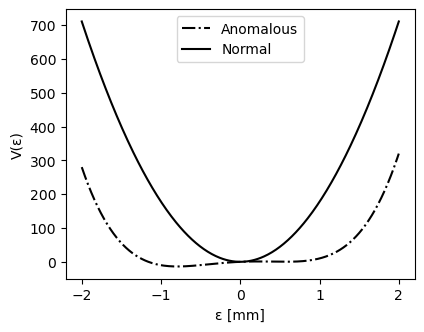

In [5]:
fig, axs = PyPlot.subplots(1, 1, figsize=(4.5, 3.5))
axs = plot(x, V1, color = "black", linestyle = "dashdot", label="Anomalous")
axs = plot(x, V2, color = "black", label="Normal")
xlabel("ε [mm]")
ylabel("V(ε)")
PyPlot.legend()
PyPlot.savefig("Potential_function.png",dpi=300)

__simulate the fuel assembly vibration (normal and abnormal)__

In [7]:
A_normal = [[0,1],
     [-A2n, - 2*xia*omegan]]
A_normal = hcat(A_normal...)'

A_abnormal = [[0,1],
     [-A2a, - 2*xia*omegan]]
A_abnormal = hcat(A_abnormal...)'


Ns = 10000000 # simulated steps, 10 million steps, 10 k seconds
t_init = 0
fs = 1000
dt = 1 / fs
t_end  = dt * Ns
ts = [t_init : dt : t_end;]

Xsn = zeros(Ns + 1) # normal condition
Xn = zeros(2)

Xsa = zeros(Ns + 1) # abnormal condition
Xa = zeros(2)

d = Normal(0, sqrt(dt))

for i = 1:Ns+1
    Xn = Xn + a_normal(A_normal, Xn, ts[i]) * dt + b(Xn, ts[i]) .* dB(dt, d)
    Xsn[i] = Xn[1]
    Xa = Xa + a_abnormal(A_abnormal, Xa, ts[i]) * dt + b(Xa, ts[i]) .* dB(dt, d)
    Xsa[i] = Xa[1]
end

#### plot Figure 2: Normal & anomalous fuel-assembly vibration.

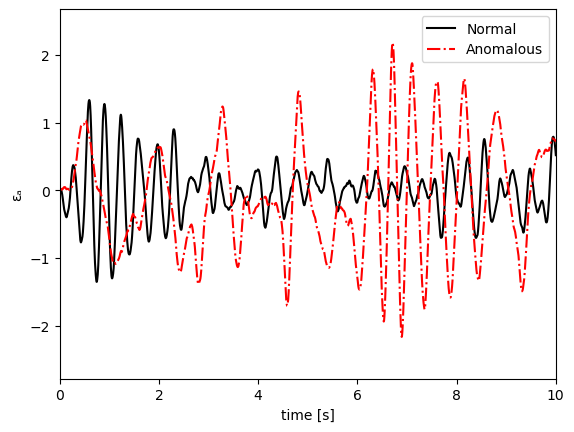

(0.0, 10.0)

In [11]:
# Figure 2 (a)
plot(ts,Xsn, color = "black", label="Normal")
plot(ts,Xsa, color = "red", linestyle = "dashdot", label="Anomalous")
xlabel("time [s]")
ylabel("εₐ")
PyPlot.legend()
PyPlot.xlim([0,10])

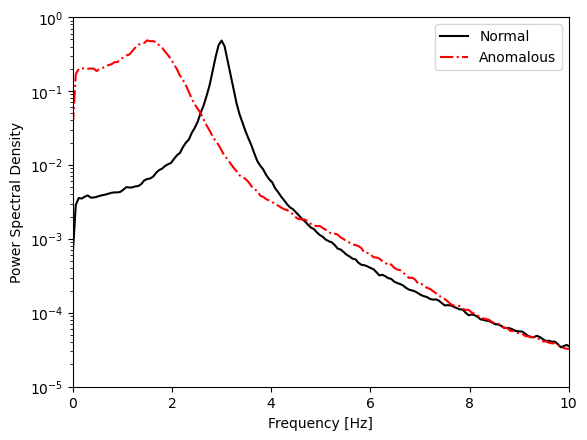

PyObject <matplotlib.legend.Legend object at 0x7f7f7acd4790>

In [15]:
# Figure 2 (b)
segment_size = 0.5*Ns
freqsN, psdN = signal.welch(Xsn[1:Int(Ns)],fs = fs,  nperseg=segment_size/300)
freqsA, psdA = signal.welch(Xsa[1:Int(Ns)],fs = fs,  nperseg=segment_size/300)
#psd = psd / psd.sum()
PyPlot.yscale("log")
plot(freqsN, psdN, color = "black", label="Normal")
plot(freqsA, psdA, color = "red", linestyle = "dashdot", label="Anomalous")
PyPlot.xlim([0,10])
PyPlot.ylim([1e-5,1])
xlabel("Frequency [Hz]")
ylabel("Power Spectral Density")
PyPlot.legend()

__combine the time series and the PSD togethor__

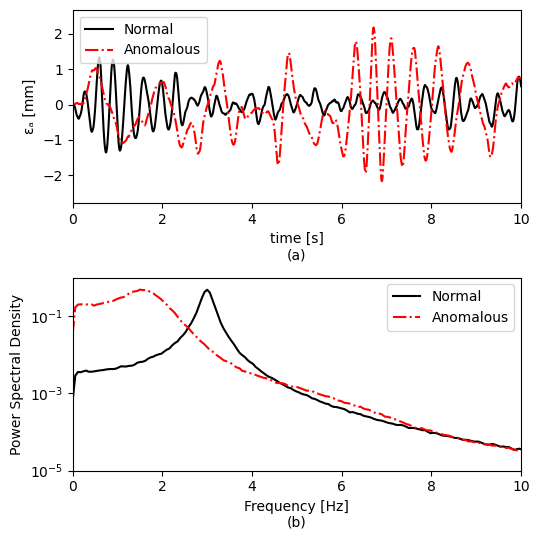

In [16]:
# Figure 2
fig, axs = PyPlot.subplots(2, 1, figsize=(5.5, 5.5))

axs[1].plot(ts,Xsn, color = "black", label="Normal")
axs[1].plot(ts,Xsa, color = "red", linestyle = "dashdot", label="Anomalous")
axs[1].set_xlabel("time [s]\n(a)")
axs[1].set_ylabel("εₐ [mm]")
axs[1].legend()
axs[1].set_xlim([0,10])

axs[2].semilogy(freqsN, psdN, color = "black", label="Normal")
axs[2].semilogy(freqsA, psdA, color = "red", linestyle = "dashdot", label="Anomalous")
axs[2].set_xlim([0,10])
axs[2].set_ylim([1e-5,1])
axs[2].set_xlabel("Frequency [Hz]\n(b)")
axs[2].set_ylabel("Power Spectral Density")
axs[2].legend()
fig.tight_layout()
PyPlot.savefig("timeSeriesPSD.png",dpi=300)

***

<hr style="border:2px solid blue"> </hr>

## in-core detector signal

In [17]:
ff = 0.98  # fraction of energy deposited in the fuel
Omega = 6.53  # MW/degree-C
M = 92.8  # MW/degree-C
mu_f = 26.3  # MW.s/degree-C
mu_c = 70.5  # MW.s/degree-C
alpha_c = 0.00001  # reactivity/degree-C
alpha_f = -0.00005  # reactivity/degree-C
P0a = 2500  # MW
Tc = 290 # degree-C
Lambd = 0.0001
lambd = 0.125
beta = 0.0065
sigma = 0.00001

n0 = 1
c0 = 1
Th0 = Tc + P0a / M
Tf0 = Th0 + ff * P0a / Omega

omeganT = 0.5 * 2 * pi # rad/s
omeganFA = 3 * 2 * pi # rad/s


xiT = 0.05
xia = 0.05


# with presence of anormaly
A1a = 10 
A2a = -50 
A3a = 0  
A4a = 100 

# normal case
A1n = 0
A2n = omeganFA ^ 2
A3n = 0 
A4n = 0 

b1 = 0.00002;

In [18]:
A_normal = [[(-beta-alpha_f*Tf0-alpha_c*Th0)/Lambd, beta / Lambd, 0,0,0,0,0,0],
             [lambd, -lambd, 0,0,0,0,0,0],
             [ff * P0a / mu_f, 0, -Omega/mu_f, Omega/mu_f, 0,0,0,0],
             [(1-ff) * P0a / mu_c, 0, Omega/mu_c, -(Omega+M)/mu_c, 0,0,1,0],
             [0,0,0,0,0,1,0,0],
             [0,0,0,0,-A2n, - 2*xia*omeganFA,0,0],
             [0,0,0,0,0,0,0,1],
             [0,0,0,0,0,0,-omeganT^2, - 2*xiT*omeganT]]
A_normal = hcat(A_normal...)'

A_abnormal = [[(-beta-alpha_f*Tf0-alpha_c*Th0)/Lambd, beta / Lambd, 0,0,0,0,0,0],
             [lambd, -lambd, 0,0,0,0,0,0],
             [ff * P0a / mu_f, 0, -Omega/mu_f, Omega/mu_f, 0,0,0,0],
             [(1-ff) * P0a / mu_c, 0, Omega/mu_c, -(Omega+M)/mu_c, 0,0,1,0],
             [0,0,0,0,0,1,0,0],
             [0,0,0,0,-A2a, - 2*xia*omeganFA,0,0],
             [0,0,0,0,0,0,0,1],
             [0,0,0,0,0,0,-omeganT^2, - 2*xiT*omeganT]]
A_abnormal = hcat(A_abnormal...)'


function N_normal(x, t)
    (x1, # nr
     x2, # c
     x3, # Tf
     x4, # Th
     x5, # ea
     x6, # ea_d
     x7, # eT
     x8, # eT_d
    ) = x
    return [
            (b1 * x5 + alpha_f * x3 + alpha_c * x4) / Lambd * x1,
            0,
            0,
            Tc * M / mu_c,
            0,
            -A1n - A3n * x5^2 - A4n * x5^3,
            0,
            0]
end

function N_abnormal(x, t)
    (x1, # nr
     x2, # c
     x3, # Tf
     x4, # Th
     x5, # ea
     x6, # ea_d
     x7, # eT
     x8, # eT_d
    ) = x
    return [
            (b1 * x5 + alpha_f * x3 + alpha_c * x4) / Lambd * x1,
            0,
            0,
            Tc * M / mu_c,
            0,
            -A1a - A3a * x5^2 - A4a * x5^3,
            0,
            0]
end

function a_normal(A, x, t)
    return A * x + N_normal(x, t)
end

function a_abnormal(A, x, t)
    return A * x + N_abnormal(x, t)
end

function b(x, t) # intensity of the activation force
    return [0.1, 0., 0., 0., 0., 15., 0., 10.]
end

function dB(dt, d)
    return [rand(d), 0., 0., 0., 0., rand(d), 0., rand(d)]
end

dB (generic function with 1 method)

In [19]:
Ns = 1000000000
t_init = 0
fs = 1000
dt = 1 / fs
t_end  = dt * Ns
ts = [t_init : dt : t_end;]

Xsn = zeros(Ns + 1) # normal condition
Xsn[1] = n0
Xsn_i = zeros(8) # normal condition
Xsn_i[1] = n0
Xsn_i[2] = c0
Xsn_i[3] = Tf0
Xsn_i[4] = Th0

Xsa = zeros(Ns + 1) # abnormal condition
Xsa[1] = n0
Xsa_i = zeros(8) # normal condition
Xsa_i[1] = n0
Xsa_i[2] = c0
Xsa_i[3] = Tf0
Xsa_i[4] = Th0

d = Normal(0, sqrt(dt))

for i = 2:Ns+1
    Xsn_i = Xsn_i + a_normal(A_normal, Xsn_i, ts[i-1]) * dt + b(Xsn_i, ts[i-1]) .* dB(dt, d)
    Xsa_i = Xsa_i + a_abnormal(A_abnormal, Xsa_i, ts[i-1]) * dt + b(Xsa_i, ts[i-1]) .* dB(dt, d)
    Xsn[i] = Xsn_i[1]
    Xsa[i] = Xsa_i[1]
end
npzwrite("X_incore_normal.npz",Xsn[:,1])
npzwrite("X_incore_abnormal.npz",Xsa[:,1])

### Attention:
- __The incore detetors signals are saved in npz files.__
- __Your PCs' memory may have exceeded or nearly exceeded. Your julia kernel may have died. In this case, restart the kernel and load the saved   X_incore_normal.npz and X_incore_abnormal.npz files for the following processing.__
- __If your PC is now with enough memory, the cell below do not need to be runned.__
- __For plotting each of the figures below, you may have to restart your kernel and run the cell below__

In [1]:
# after restarting the kernel
# import the following packages
using NPZ
using PyPlot
using Random, Distributions
using DSP
using FFTW
using LinearAlgebra
using PyCall
@pyimport scipy.signal as signal
# load the saved X_incore_normal.npz and X_incore_abnormal.npz
Xsn = npzread("X_incore_normal.npz")
Xsa = npzread("X_incore_abnormal.npz")

# redefine the following parameters
Ns = 1000000000
t_init = 0
fs = 1000
dt = 1 / fs
t_end  = dt * Ns
ts = [t_init : dt : t_end;];

┌ Warning: `@pyimport foo` is deprecated in favor of `foo = pyimport("foo")`.
│   caller = _pywrap_pyimport(::PyObject) at PyCall.jl:413
└ @ PyCall /home/xxc90/.julia/packages/PyCall/BD546/src/PyCall.jl:413


1000000001-element Array{Float64,1}:
      0.0
      0.001
      0.002
      0.003
      0.004
      0.005
      0.006
      0.007
      0.008
      0.009
      0.01
      0.011
      0.012
      ⋮
 999999.989
 999999.99
 999999.991
 999999.992
 999999.9929999999
 999999.994
 999999.9950000001
 999999.996
 999999.997
 999999.998
 999999.9990000001
      1.0e6

__plot neutron density time series__

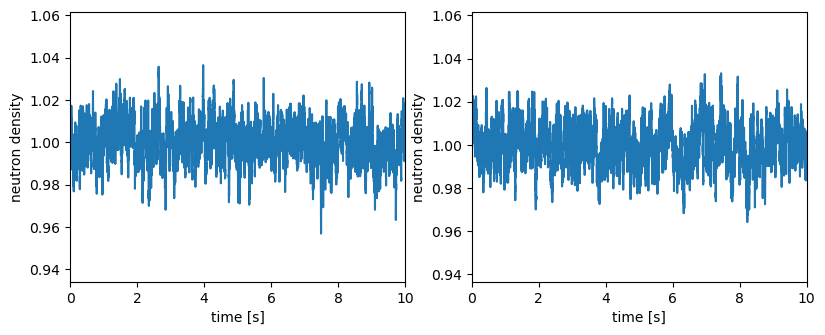

(0.0, 10.0)

In [2]:
x_lim = 10
fig, axs = PyPlot.subplots(1, 2, figsize=(9.5, 3.5))
axs[1].plot(ts,Xsn[:,1])
axs[2].plot(ts,Xsa[:,1])
axs[1].set_xlabel("time [s]")
axs[1].set_ylabel("neutron density")
axs[2].set_xlabel("time [s]")
axs[2].set_ylabel("neutron density")

axs[1].set_xlim([0,x_lim])
axs[2].set_xlim([0,x_lim])

#### plot Figure 6 (a): Typical time series of neutron noise in the first 3 seconds.

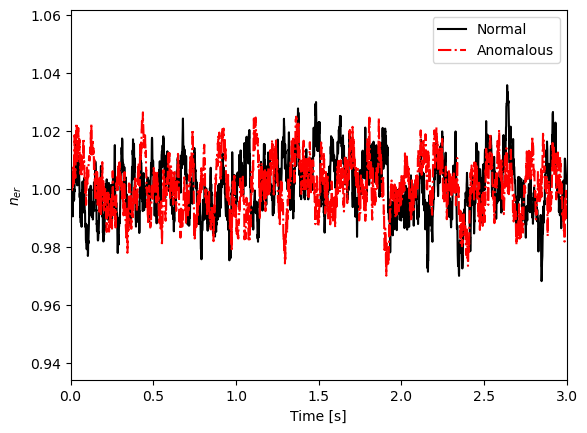

In [2]:
plot(ts[2:end], Xsn[2:end], color = "black", label="Normal")
plot(ts[2:end], Xsa[2:end], color = "red", linestyle = "dashdot", alpha=1, label="Anomalous")
PyPlot.xlim([0,3])
xlabel("Time [s]")
ylabel(L"n_{er}")
PyPlot.legend(loc="upper right")

PyPlot.savefig("in-coreTimeSeries.png", bbox_inches = "tight",
    pad_inches = 0, dpi=300)

#### plot Figure 7 (a): Typical PSD of neutron noise from in-core dector and ex-core detector.

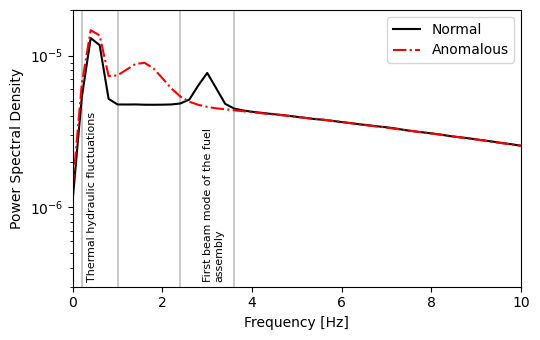

In [8]:
segment_size = 0.5*Ns
freqsN, psdN = signal.welch(Xsn[:,1],fs = fs,  nperseg=segment_size/100000)
freqsA, psdA = signal.welch(Xsa[:,1],fs = fs,  nperseg=segment_size/100000)
#psd = psd / psd.sum()

fig, ax = PyPlot.subplots(1, 1, figsize=(5.5, 3.5))


ax.semilogy(freqsN, psdN, color = "black", label="Normal")
ax.semilogy(freqsA, psdA, color = "red", linestyle = "dashdot", label="Anomalous")

plt.vlines([0.2, 1, 2.4, 3.6], 0, 1, transform=ax.get_xaxis_transform(), linewidth=0.3, color="k")

t1 = ("Thermal hydraulic fluctuations")
PyPlot.text(0.5, 3.2e-7, t1, ha="left", rotation=90, wrap=true, fontsize=8)

t2 = ("First beam mode of the fuel \nassembly")
PyPlot.text(3.3, 3.2e-7, t2, ha="left", rotation=90, wrap=true, fontsize=8)

PyPlot.xlim([0,10])
PyPlot.ylim([3e-7,2e-5])
xlabel("Frequency [Hz]")
ylabel("Power Spectral Density")
PyPlot.legend()
fig.tight_layout()
PyPlot.savefig("in-corePSD.png", bbox_inches = "tight",
    pad_inches = 0, dpi=300)

---

<hr style="border:2px solid blue"> </hr>

## reactor core barrel and pressure vessel vibration simulation

$M\ddot{\varepsilon}+C\dot{\varepsilon}+K\varepsilon = \mathbf{F}$
$\to M^{-1}M\ddot{\varepsilon}+M^{-1}C\dot{\varepsilon}+M^{-1}K\varepsilon = M^{-1}\mathbf{F}$

where $M=\begin{bmatrix} m_1&0\\0&m_2\end{bmatrix}, C=\begin{bmatrix}c_1+c_2&-c_2\\-c_2&c_2\end{bmatrix}, K=\begin{bmatrix}k_1+k_2&-k_2\\-k_2&k_2\end{bmatrix}, \mathbf{F} = \begin{bmatrix}F_1\\F_2\end{bmatrix}$.

$\to \ddot{\varepsilon}+\hat{C}\dot{\varepsilon}+\hat{K}\varepsilon = \hat{\mathbf{F}}$

where $M^{-1}=\begin{bmatrix}\frac{1}{m_1}&0\\0&\frac{1}{m_2}\end{bmatrix}, \hat{C}=M^{-1}C=\frac{c_2}{m_2}\begin{bmatrix}\frac{m_2}{m_1}\alpha_1&-\frac{m_2}{m_1}\\-1&1\end{bmatrix}$ in which $\alpha_1 = \frac{c_1+c_2}{c_2}$, $\hat{K}=M^{-1}K=\frac{k_2}{m_2}\begin{bmatrix}\frac{m_2}{m_1}\alpha_2&-\frac{m_2}{m_1}\\-1&1\end{bmatrix}$ in which $\alpha_2 = \frac{k_1+k_2}{k_2}$.

Notice that $\hat{K}$ is symmetric and the natural frequencies of the system are the square root of the eigenvalues of $\hat{K}$.


Let $\varepsilon_1=x_1, \varepsilon_2 = x_2, \dot{\varepsilon}_1=x_3, \dot{\varepsilon}_2=x_4$.

$\dot{x_1} = x_3$

$\dot{x_2} = x_4$

$\dot{x_3} = \hat{C}_{11}x_3 + \hat{C}_{12}x_4+\hat{K}_{11}x_1 + \hat{K}_{12}x_2 + \hat{F_1}$

$\dot{x_4} = \hat{C}_{21}x_3 + \hat{C}_{22}x_4+\hat{K}_{21}x_1 + \hat{K}_{22}x_2 + \hat{F_2}$

Or simply:

$\dot{\mathbf{x}} = \begin{bmatrix} \mathbf{0}&\mathbf{I}\\ \mathbf{-\hat{K}}&\mathbf{-\hat{C}} \end{bmatrix}\mathbf{x}+ \begin{bmatrix}0\\0\\F_1\\F_2\end{bmatrix}$

#### attention:
- __just in case, your kernel died again, the cell below__

In [1]:
using NPZ
using PyPlot
using Random, Distributions
using DSP
using FFTW
using LinearAlgebra
using PyCall
@pyimport scipy.signal as signal

┌ Warning: `@pyimport foo` is deprecated in favor of `foo = pyimport("foo")`.
│   caller = _pywrap_pyimport(::PyObject) at PyCall.jl:413
└ @ PyCall /home/xxc90/.julia/packages/PyCall/BD546/src/PyCall.jl:413


In [2]:
A = [      0.0       0.0      1.0       0.0;
      0.0       0.0      0.0       1.0;
 -11000.0     411.765  -19.4118    1.76471;
   2916.67  -2916.67    12.5     -12.5]
bb = [0 0 0 0; 0 0 0 0; 0 0 1.4 0; 0 0 0 1.4];

In [3]:
Ns = 1000000000
t_init = 0
fs = 1000
dt = 1 / fs
t_end  = dt * Ns
ts = [t_init : dt : t_end;]

XsCP = zeros((Ns + 1, 2))
XsCP_i = [0; 0; 0; 0]

d = Normal(0, sqrt(dt))

for i = 2:Ns+1
    XsCP_i = XsCP_i + A * XsCP_i * dt + bb * [0; 0; rand(d); rand(d)]
    XsCP[i,1] = XsCP_i[1]
    XsCP[i,2] = XsCP_i[2]
end

In [6]:
# save the core barrel displacement time sereis because you do not want to run it again after the kernel die
npzwrite("X_corebarrel.npz",XsCP[:,2])

In [4]:
segment_size = 0.5*Ns
freqsPV, psdPV = signal.welch(XsCP[:,1],fs = fs,  nperseg=segment_size/10000)
freqsCB, psdCB = signal.welch(XsCP[:,2],fs = fs,  nperseg=segment_size/10000);

([0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18  …  499.82, 499.84000000000003, 499.86, 499.88, 499.90000000000003, 499.92, 499.94, 499.96000000000004, 499.98, 500.0], [9.06295923127543e-8, 4.473372601043708e-7, 5.332152299050628e-7, 5.345978537346456e-7, 5.336903669146587e-7, 5.321881667077243e-7, 5.325549251961639e-7, 5.342757436389524e-7, 5.362932865613962e-7, 5.318883017637696e-7  …  2.462890865317784e-13, 2.472865867777675e-13, 2.474869326109366e-13, 2.4711685198521056e-13, 2.4836537110601535e-13, 2.480066949741969e-13, 2.479196237330048e-13, 2.472537728109319e-13, 2.4595937847390824e-13, 1.230893717392068e-13])

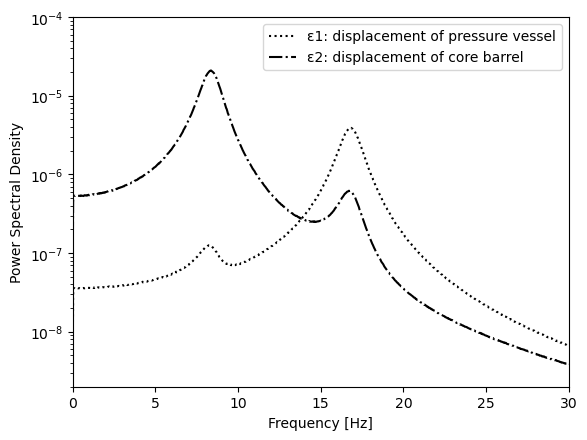

PyObject <matplotlib.legend.Legend object at 0x7fc547d2f8e0>

In [9]:
#freqs_total, psd_total = signal.welch(XsCP_total,fs = fs,  nperseg=segment_size/10000)
#psd = psd / psd.sum()
semilogy(freqsPV, psdPV, color = "black", linestyle = ":", label="ε1: displacement of pressure vessel")
semilogy(freqsCB, psdCB, color = "black", linestyle = "dashdot", label="ε2: displacement of core barrel")
#semilogy(freqs_total, psd_total, color = "red", label="ε1 + ε2")
PyPlot.xlim([0,30])
PyPlot.ylim([2e-9,1e-4])
xlabel("Frequency [Hz]")
ylabel("Power Spectral Density")
PyPlot.legend()

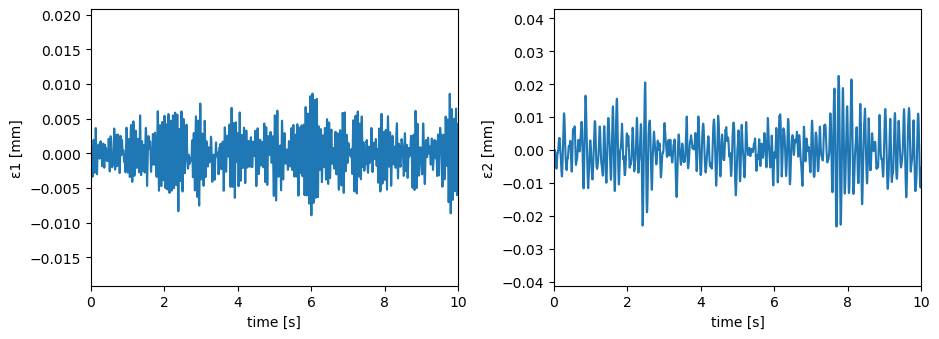

In [13]:
x_lim = 10
fig, axs = PyPlot.subplots(1, 2, figsize=(9.5, 3.5))
axs[1].plot(ts,XsCP[:,1])
axs[2].plot(ts,XsCP[:,2])
axs[1].set_xlabel("time [s]")
axs[1].set_ylabel("ε1 [mm]")
axs[2].set_xlabel("time [s]")
axs[2].set_ylabel("ε2 [mm]")

axs[1].set_xlim([0,x_lim])
axs[2].set_xlim([0,x_lim])
fig.tight_layout()

#### plot Figure 4: Typical core barrel and pressure vessel vibration data.

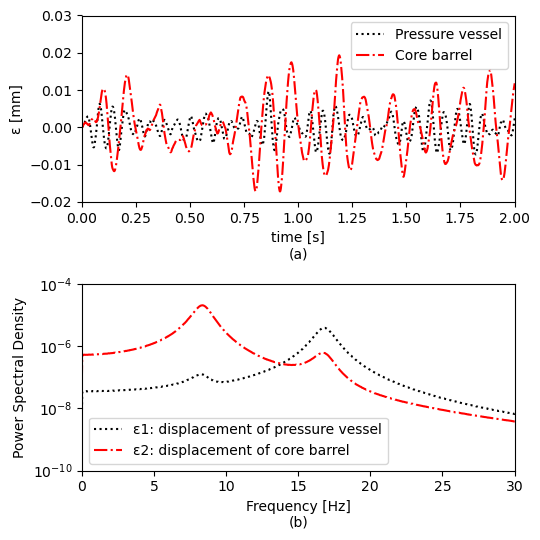

In [5]:
fig, axs = PyPlot.subplots(2, 1, figsize=(5.5, 5.5))

axs[1].plot(ts,XsCP[:,1], color = "black", linestyle = ":", label="Pressure vessel")
axs[1].plot(ts,XsCP[:,2], color = "red", linestyle = "dashdot", alpha=1, label="Core barrel")
axs[1].set_xlabel("time [s]\n(a)")
axs[1].set_ylabel("ε [mm]")
axs[1].legend()
axs[1].set_xlim([0,2])
axs[1].set_ylim([-0.02,0.03])

axs[2].semilogy(freqsPV, psdPV, color = "black", linestyle = ":", label="ε1: displacement of pressure vessel")
axs[2].semilogy(freqsCB, psdCB, color = "red", linestyle = "dashdot", label="ε2: displacement of core barrel")


axs[2].set_xlim([0,30])
axs[2].set_ylim([1e-10,1e-4])
axs[2].set_xlabel("Frequency [Hz]\n(b)")
axs[2].set_ylabel("Power Spectral Density")
axs[2].legend()
fig.tight_layout()
PyPlot.savefig("timeSeriesPSD_CP.png",dpi=300)

<hr style="border:2px solid blue"> </hr>

## get the ex-core detector signal

#### attention:
- __if you do not have a PC with enough memery, restart your kernel again; do not wait it dies by itself, that is just a waste of time.__
- __in case, you restart the kernel, run the cell below__

In [1]:
using NPZ
using PyPlot
using Random, Distributions
using DSP
using FFTW
using LinearAlgebra
using PyCall
@pyimport scipy.signal as signal
XsCB = npzread("X_corebarrel.npz");

┌ Warning: `@pyimport foo` is deprecated in favor of `foo = pyimport("foo")`.
│   caller = _pywrap_pyimport(::PyObject) at PyCall.jl:413
└ @ PyCall /home/xxc90/.julia/packages/PyCall/BD546/src/PyCall.jl:413


1000000001-element Array{Float64,1}:
 0.0
 0.0
 6.176012925766823e-5
 0.0001817162802797882
 0.000326645709644505
 0.0004454499658479463
 0.0005512145508591169
 0.0006847984724651339
 0.0008120448744720391
 0.0008920083277780216
 0.0009027114903982421
 0.0009656881669243163
 0.0010368231734011705
 ⋮
 0.009192972182532682
 0.008891978322276603
 0.00856488991250393
 0.008233096735518258
 0.00796167460596802
 0.007618725300668905
 0.007291276036314596
 0.006956488337229305
 0.006585660674149382
 0.006242355129849745
 0.005887394977104995
 0.005578554743009895

In [3]:
Xsn = npzread("X_incore_normal.npz")
Xsa = npzread("X_incore_abnormal.npz")
mu = 0.4
Xern = Xsn .* (1 .- mu * XsCB)
Xera = Xsa .* (1 .- mu * XsCB);

In [8]:
# save the ex-core detector signals
npzwrite("X_excore_normal.npz",Xern[:,1])
npzwrite("X_excore_abnormal.npz",Xera[:,1])

#### plot Figure 7 (b): Typical PSD of neutron noise from in-core dector and ex-core detector.

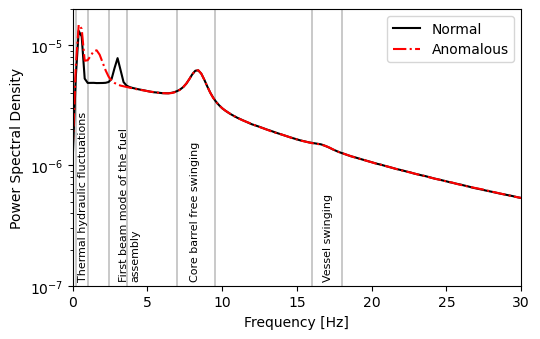

In [6]:
Ns = 1000000000
t_init = 0
fs = 1000
dt = 1 / fs
t_end  = dt * Ns
ts = [t_init : dt : t_end;];

segment_size = 0.5*Ns
freqsErn, psdErn = signal.welch(Xern[:,1],fs = fs,  nperseg=segment_size/100000)
freqsEra, psdEra = signal.welch(Xera[:,1],fs = fs,  nperseg=segment_size/100000)
#psd = psd / psd.sum()


fig, ax = PyPlot.subplots(1, 1, figsize=(5.5, 3.5))


ax.semilogy(freqsErn, psdErn, color = "black", label="Normal")
ax.semilogy(freqsEra, psdEra, color = "red", linestyle = "dashdot", label="Anomalous")
PyPlot.xlim([0,30])
PyPlot.ylim([1e-7,2e-5])

plt.vlines([0.2, 1, 2.4, 3.6, 7,9.5,16,18], 0, 1, transform=ax.get_xaxis_transform(), linewidth=0.3, color="k")

t1 = ("Thermal hydraulic fluctuations")
PyPlot.text(0.9, 1.1e-7, t1, ha="left", rotation=90, wrap=true, fontsize=8)

t2 = ("First beam mode of the fuel \nassembly")
PyPlot.text(4.3, 1.1e-7, t2, ha="left", rotation=90, wrap=true, fontsize=8)

t3 = ("Core barrel free swinging")
plt.text(8.4, 1.1e-7, t3, ha="left", rotation=90, wrap=true, fontsize=8)

t4 = ("Vessel swinging")
PyPlot.text(17.3, 1.1e-7, t4, ha="left", rotation=90, wrap=true, fontsize=8)


xlabel("Frequency [Hz]")
ylabel("Power Spectral Density")
PyPlot.legend()
fig.tight_layout()
PyPlot.savefig("ex-corePSD.png", bbox_inches = "tight", pad_inches = 0, dpi=300)

#### plot Figure 6 (b): Typical time series of neutron noise in the first 3 seconds.

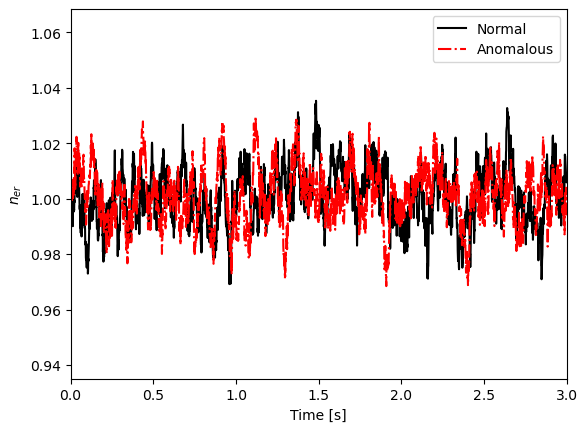

In [7]:
plot(ts[2:end], Xern[2:end], color = "black", label="Normal")
plot(ts[2:end], Xera[2:end], color = "red", linestyle = "dashdot", alpha=1, label="Anomalous")
PyPlot.xlim([0,3])
xlabel("Time [s]")
ylabel(L"n_{er}")
PyPlot.legend(loc="upper right")

PyPlot.savefig("ex-coreTimeSeries.png", bbox_inches = "tight",
    pad_inches = 0, dpi=300)